<img src="unet_arch.png" title="U-net arch.">

In [2]:
import os
import natsort
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.tensorboard import SummaryWriter

import torch.nn as nn
import torch.nn.functional as F

from torchmetrics import JaccardIndex

from model import Unet
from load import CustomDataset

In [47]:
import sys

#Loss functions from: https://github.com/JunMa11/SegLoss
sys.path.append('SegLoss-master/losses_pytorch')
from dice_loss import IoULoss

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [49]:
#parameters
H = 128#256
W = 128#256
size = (H,W)
batch_size = 2
num_epochs = 50
learn_rate = 1.e-4

In [50]:
#Set seed for reproducibility
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [51]:
seeding(123)

## Load data

In [53]:
#Define a transform object that takes the data to pytorch tensor form and normalizes it
img_transform = Compose( [Resize(size), ToTensor()] )#, Normalize(mean=(0.5,),std=(0.5,))] );
msk_transform = Compose( [Resize(size)] );

In [54]:
train_set = CustomDataset(main_dir='./data/train/',img_transform=img_transform,msk_transform=msk_transform)
valid_set = CustomDataset(main_dir='./data/test/',img_transform=img_transform,msk_transform=msk_transform)

In [55]:
print("Dataset size:\nTrain: {0} Validation: {1}".format(len(train_set),len(valid_set)))

Dataset size:
Train: 102 Validation: 42


In [56]:
img, msk = train_set[0]
img.shape, msk.shape

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

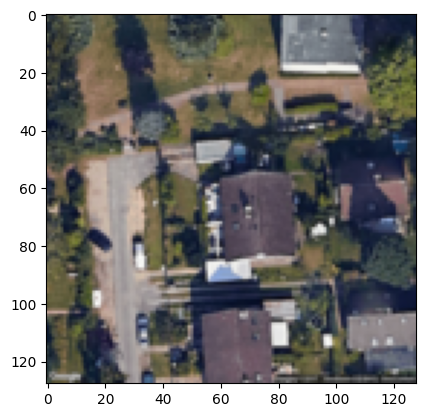

In [57]:
plt.imshow(img.permute(1,2,0))

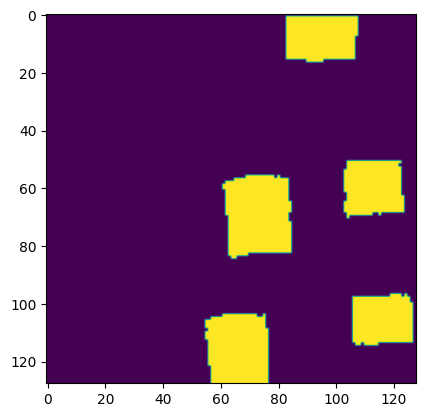

In [58]:
plt.imshow(msk[0])

In [59]:
train_loader = DataLoader(
    dataset = train_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)
valid_loader = DataLoader(
    dataset = valid_set,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

## The model

In [13]:
model = Unet().to(device)

## Loss function

In [14]:
#From https://github.com/nikhilroxtomar/Retina-Blood-Vessel-Segmentation-in-PyTorch/blob/main/UNET/loss.py
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [15]:
#Binary cross entropy
loss_fn = IoULoss() #DiceBCELoss()

## Optimizer

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=False)

## Training epoch loop

In [17]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0
    
    #Use an enumeration instead of an iterator to track the batch index and do reporting
    for i, data in enumerate(train_loader):
        #training instances are input + mask pairs
        inputs, masks = data
        inputs, masks = inputs.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
        
        #zero the gradients
        optimizer.zero_grad()
        
        #make predictions for this batch
        outputs = model(inputs)
        
        ##*****************************************
        #for layer in model.children():
        #    if isinstance(layer, nn.Conv2d):
        #        print(torch.isfinite(layer.state_dict()['weight'].grad))
        ##*****************************************
        
        #compute loss and its gradient
        loss = loss_fn(outputs, masks)
        loss.backward()
        
        #adjust the weights
        optimizer.step()
        
        #gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 #loss per batch
            print(' batch {} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
        
        del inputs
        del masks
        torch.cuda.empty_cache()
        
    return last_loss

## Main loop

In [18]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/unet_trainer_{}'.format(timestamp))

In [19]:
epoch_number = 0
best_vloss = 1_000_000.
losslist = []
vlosslist = []

torch.autograd.set_detect_anomaly(True)

for epoch in range(num_epochs):
    print('EPOCH {}'.format(epoch_number + 1))
    
    #Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    #To do reporting gradients do not need to be on
    model.train(False)
    
    #Pull batches fron validation data to validate
    running_vloss = 0
    for i, vdata in enumerate(valid_loader):
        vinputs, vmasks = vdata
        vinputs, vmasks = vinputs.to(device, dtype=torch.float32), vmasks.to(device, dtype=torch.float32)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vmasks)
        running_vloss += vloss
    
    avg_vloss = running_vloss / (i+1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    #losslist.append(avg_loss)
    #vlosslist.append(avg_vloss)
    
    
    #Log the runnig loss averaged per batch for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                      {'Training': avg_loss, 'Validation': avg_vloss},
                      epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        
    epoch_number += 1
    del vinputs
    del vmasks
    torch.cuda.empty_cache()

EPOCH 1
 batch 10 loss: 1.5884505033493042
LOSS train 1.5884505033493042 valid 1.7120850086212158
EPOCH 2
 batch 10 loss: 1.5169926524162292
LOSS train 1.5169926524162292 valid 2.0070128440856934
EPOCH 3
 batch 10 loss: 1.444407308101654
LOSS train 1.444407308101654 valid 2.1096577644348145
EPOCH 4
 batch 10 loss: 1.385660457611084
LOSS train 1.385660457611084 valid 2.438966751098633
EPOCH 5
 batch 10 loss: 1.3515211343765259
LOSS train 1.3515211343765259 valid 1.5657553672790527
EPOCH 6
 batch 10 loss: 1.3362690091133118
LOSS train 1.3362690091133118 valid 2.3851513862609863
EPOCH 7
 batch 10 loss: 1.3271088123321533
LOSS train 1.3271088123321533 valid 1.6018577814102173
EPOCH 8
 batch 10 loss: 1.3113896608352662
LOSS train 1.3113896608352662 valid 1.5519403219223022
EPOCH 9
 batch 10 loss: 1.3009114861488342
LOSS train 1.3009114861488342 valid 1.5311729907989502
EPOCH 10
 batch 10 loss: 1.2927854776382446
LOSS train 1.2927854776382446 valid 1.5210115909576416
EPOCH 11
 batch 10 loss:

## Result

In [62]:
#To load the saved version of the model
saved_model = Unet()
saved_model.load_state_dict(torch.load('./model_20220924_181205_17_iou'))

<All keys matched successfully>

In [77]:
it_val = iter(valid_loader)
iou_av = 0
iou_sq = 0
cnt = 0
for it in it_val:
    input_im, masks = it
    #print(type(input_im[0]), input_im[0].shape)
    #plt.imshow(input_im[0].permute(1,2,0))
    #plt.imshow(masks[0][0])
    
    out = saved_model(input_im)
    #print(type(out[0][0]), out[0][0].shape)
    #plt.imshow(out[0][0].detach().numpy())
    ##Jackard index (IoU score)
    jaccard = JaccardIndex(num_classes=2)
    iou_sc = jaccard(out[0][0], masks[0][0])
    iou_av += iou_sc.item()
    iou_sq += iou_sc.item()**2
    cnt += 1
iou_av /= cnt
iou_fl = np.sqrt(iou_sq/cnt - iou_av**2)
print("IoU score: {0:.3f}+/-{1:.3f}".format(iou_av,iou_fl))

IoU score: 0.819+/-0.049
